In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()

In [3]:
counter = 0 
for (test, revealed_targets, sample_prediction) in iter_test:
    if counter == 0:
        print(test.head())
        print(revealed_targets.head())
        print(sample_prediction.head())
    sample_prediction['target'] = 0 
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   
3         3      478                  0      2872317.54   
4         4      478                  0       740059.14   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                       -1         0.999875   11548975.43        NaN   
1                       -1         1.000245    3850033.97        NaN   
2                        1         1.000584    4359198.25        NaN   
3                       -1         0.999802   27129551.64        NaN   
4                       -1         0.999886    8880890.78        NaN   

   near_price  bid_price  bid_size  ask_price  ask_size  wap   row_id  
0         NaN  

In [4]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn as sk
import tensorflow_probability as tfp 
import warnings 
import time 
import gc 
import torch 
import torch.nn as nn
import lightgbm as lgb 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from torch.utils.data import Dataset, DataLoader, TensorDataset
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error

In [6]:
train = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")


plt.rcParams.update({"font.size" : 16})

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
class CFG:
    BATCH_SIZE = 32
    N_EPOCHS = 500
    LEARNING_RATE = 0.01
    N_FOLDS = 5
    TARGET_COLS = ['target']
    SEED = 2023
    N_ASSETS = train['stock_id'].nunique()
    N_TIMESTEPS  = 1
    
CFG = CFG()
set_seed(CFG.SEED)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [9]:
train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [10]:
train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


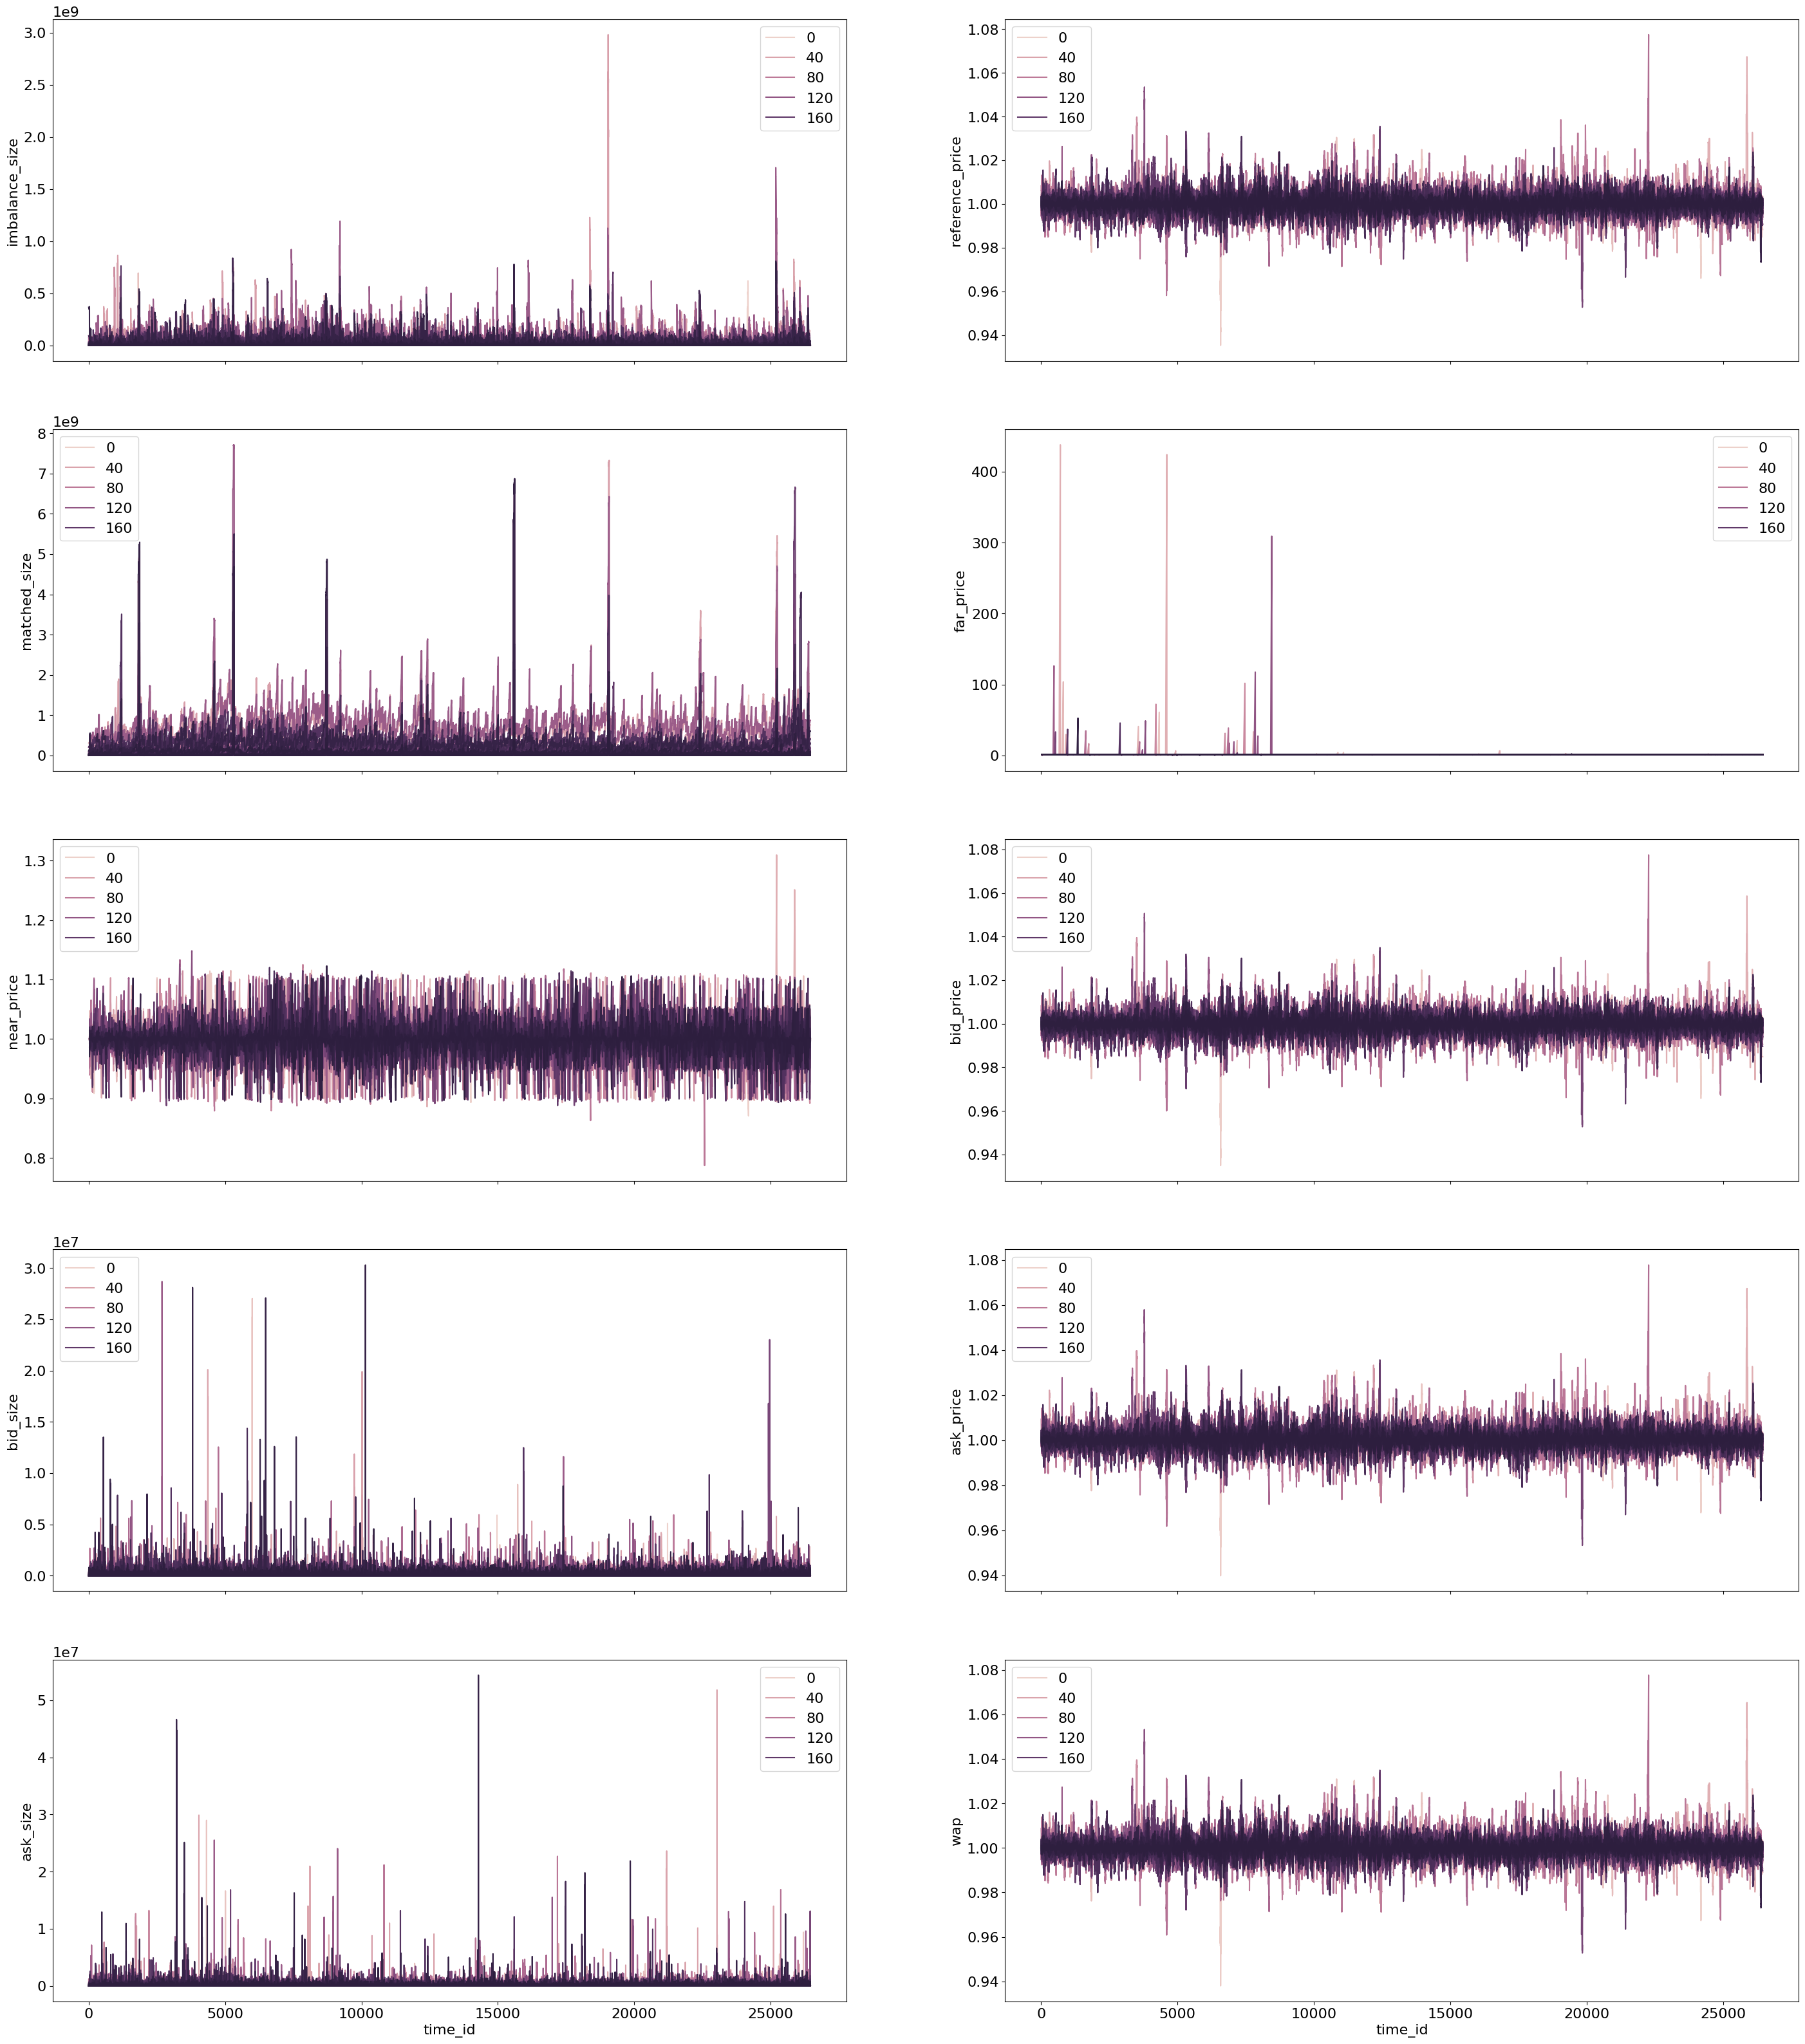

In [12]:
def plot_hist(df):
    
    cols = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id'], axis = 1).columns)
    
    fig, axs = plt.subplots(5,2, sharex = True, figsize=(35,40))
    
    for col, ax in zip(cols, axs.ravel()):
        sns.lineplot(data = df, x = 'time_id', y = df[col], hue='stock_id', ax = ax)
        ax.legend(loc = 'best')

plot_hist(train)

<Axes: xlabel='target', ylabel='Count'>

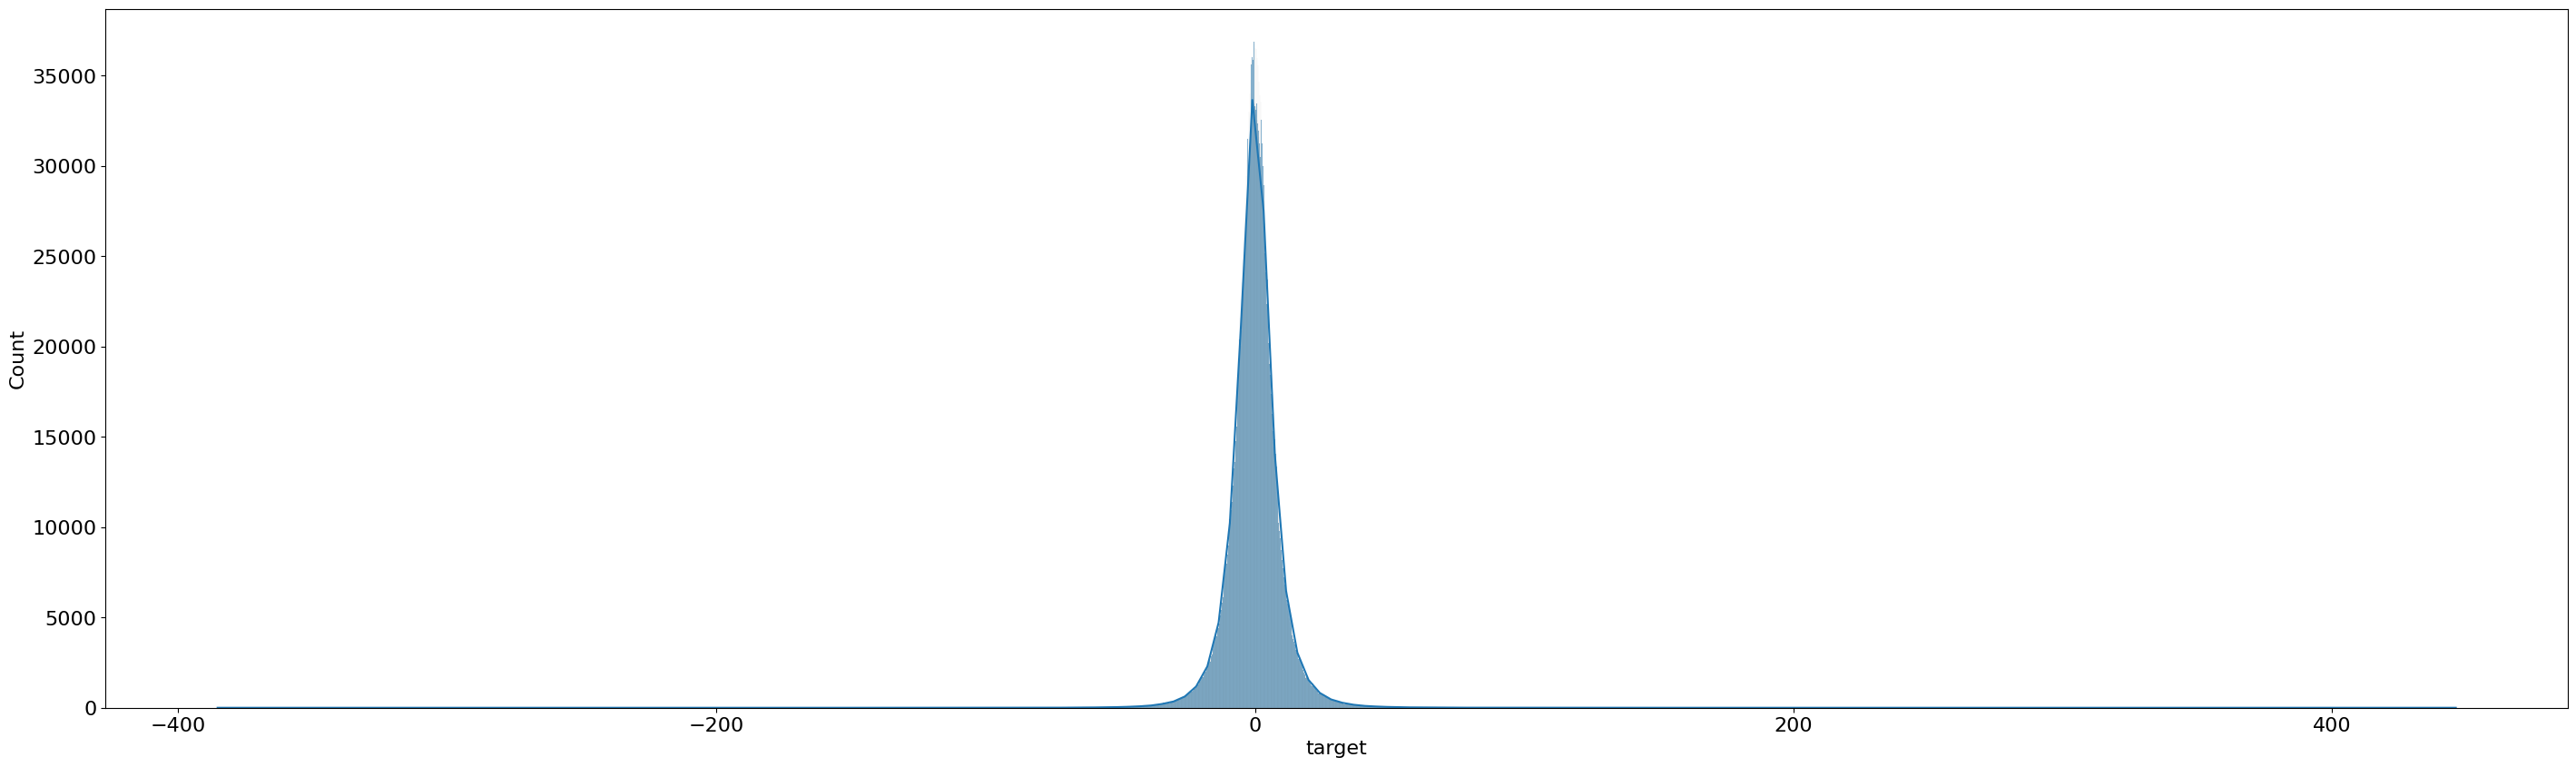

In [14]:
plt.figure(figsize=(35,10))
sns.histplot(data = train, x = 'target', kde = True)

In [11]:
def OHE(df, column):
        if df[column].isna().any():
            df[column].fillna(0)
        for value in [-1, 0, 1]:
            df[column+"_"+str(value)] = [1 if x==value else 0 for x in df[column]]
        df.drop(column, axis=1, inplace=True)
    
def temportal_data_aggregation(df):
    for column in df.columns:
        if column in ['imbalance_size', 'reference_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']:
            for roll in [5, 15, 60, 240]:
                df[f'{column}_{roll}'] = df.groupby(['stock_id'], as_index=False)[column].rolling(roll).mean().sort_index().drop('stock_id', axis=1)
                
def preprocess(df):
    df['log_return'] = np.log(df['wap'])
    temportal_data_aggregation(df)
    OHE(df, 'imbalance_buy_sell_flag')
    df.fillna(0, inplace=True)
    
preprocess(train)

In [26]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in a groups to avoid potential leaking info from train into test if the model has windowed or lag features. 
    Provides train/test indices to split time series data samples that are observed at fixed time intervals according to a third-party provided groups.
    In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate. 
    This cross-validation object is a variation of :class: `KFold`,
    In the Kth split, it returns first K folds as train set and the (K+1)th fold as test set. 
    The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.
    Read more in the :ref: `User Guide <cross_validation>`.
    
    Parameters
    -------------
    
    n_plits: int, default=5
        Number of splits. Must be at least 2.
    stacking_mode : bool, default = True
        Whether to provide an additional set to test a stacking classifier or not.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    max_val_group_size : int, default = Inf
        Maximum group size for a single validation set.
    max_test_group_size : int , default = Inf
        discard this number of groups from the end of each train split, if stacking_mode = True and None
            it defaults to max_val_group_size
    val_group_gap : int, default = None
        Gap between train and validation 
    test_group_gap : int, default = None 
        Gap between validation and test, if stacking_mode = True and None
        it defaults to val_group_gap
    
    """
    
    @_deprecate_positional_args
    def __init__(self,
                n_splits = 5,
                *,
                max_train_group_size = np.inf,
                max_val_group_size = np.inf,
                max_test_group_size = np.inf,
                val_group_gap = None,
                test_group_gap = None, 
                verbose = False):
        super().__init__(n_splits, shuffle=False, random_state = None)
        self.max_train_group_size = max_train_group_size
        self.max_val_group_size = max_val_group_size
        self.max_test_group_size = max_test_group_size
        self.val_group_gap = val_group_gap
        self.test_group_gap = test_group_gap
        self.verbose = verbose
        
    def split(self, X, y = None, groups = None):
        return self.split_standard(X, y, groups)
    
    def split_standard(self, X, y=None, groups=None):
        """Generate indices to split data into training and validation set. 
        Parameters
        ----------
        X : array -like of shape (n_samles, n_features)
            Training data, where n_samples is the number of samples and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibilty
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into train/validation set.
        Yields
        -------
        train : ndarray
            The training set indices for that split.
        val : ndarray 
            The validation set indices for that split.
        """
        if groups is None:
            raise ValueError("The groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_splits = self.n_splits 
        group_gap = self.val_group_gap
        max_val_group_size = self.max_val_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index = True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
            if n_folds > n_groups:
                raise "ValueError"((f"Cannot have number of folds={n_folds} greater than the number of groups={n_groups}"))
        group_val_size = min(n_groups // n_folds, max_val_group_size)
        group_val_starts = range(n_groups - n_splits * group_val_size, n_groups, group_val_size)
        
        for group_val_start in group_val_starts:
            train_array = []
            val_array = []
            
            group_st = max(0, group_val_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_val_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(np.concatenate((train_array, train_array_tmp)), axis = None), axis = None)
            
            train_end = train_array.size
            
            for val_group_idx in unique_groups[group_val_start:
                                              group_val_start + group_val_size]:
                val_array_tmp = group_dict[val_group_idx]
                val_array = np.sort(np.unique(
                    np.concatenate((val_array, val_array_tmp))
                ,axis = None), axis = None)
            
            val_array = val_array[group_gap:]
            
            if self.verbose > 0:
                pass
            
            yield [int(i) for i in train_array], [int(i) for i in val_array]

<>:91: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:91: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_32/2825726306.py:91: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  raise "ValueError"((f"Cannot have number of folds={n_folds} greater than the number of groups={n_groups}"))


### Model

In [37]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1d1 = nn.Conv1d(200, 256, 2)
        self.conv1d2 = nn.Conv1d(256, 512, 2)
        self.conv1d3 = nn.Conv1d(512, 1024, 2)
        
        self.pool1d1 = nn.AvgPool1d(2)
        self.pool1d2 = nn.AvgPool1d(2)
        self.pool1d3 = nn.AvgPool1d(2)
        
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
        
        self.linear1 = nn.Linear(8192, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, 200)
        
        self.flat = nn.Flatten()
        
    def forward(self, inputs):
        x = self.conv1d1(inputs)
        x = nn.ReLU()(x)
        x = self.pool1d1(x)
        
        x = self.conv1d2(x)
        x = nn.ReLU()(x)
        x = self.pool1d2(x)
        
        x = self.conv1d3(x)
        x = nn.ReLU()(x)
        #x = self.pool1d3(x)
        
        out = self.flat(x)
        
        out = self.linear1(out)
        out = nn.ReLU()(out)
        out = self.dropout1(out)
        
        out = self.linear2(out)
        out = nn.ReLU()(out)
        out = self.dropout2(out)
        
        out = self.linear3(out)
        out = nn.ReLU()(out)
        out = self.dropout3(out)
        
        out = self.linear4(out)
        out = nn.ReLU()(out)
        
        output = self.linear5(out)
        
        return output 

In [35]:
def pad_df(df):
    missing_ids = list(set(np.arange(0,200)) - set(df.index) )
    for id in missing_ids:
        df.loc[id] = 0
    df.sort_index(inplace = True)
    return df

def get_dataset(df):
    X = []
    y = []
    
    for name, group in df.groupby('time_id'):
        group = group.set_index('stock_id')
        if len(group) < 200:
            group = pad_df(group)
        features = torch.tensor(group.drop(['date_id','row_id','far_price','near_price','target'], axis = 1).values, dtype = torch.float32)
        labels = group['target'].values
        X.append(features)
        y.append(labels)
    X_ = torch.stack(X)
    y_ = torch.tensor(np.array(y), dtype = torch.float32)
    return TensorDataset(X_, y_)

In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def get_score(y_val , y_pred):
    all_scores = []
    for i in range(len(y_val)):
        score = mean_absolute_error(y_val[i], y_pred[i])
        all_scores.append(score)
    return np.mean(all_scores)

def train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device):
    losses = AverageMeter()
    model.train()
    for setp, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.update(loss.item(), labels.size(0))
        loss.backward()
        optimizer.step()
    return losses.avg

def valid_fn(valid_dataloader, model, loss_fn, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    for step, (input_ids, labels) in enumerate(valid_dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
        losses.update(loss.item(), batch_size)
        preds.append(outputs.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def train_loop(train, val, fold):
    print(f"------------------------ Fold: {fold+1} ------------------------------------")
    
    train_ds = get_dataset(train)
    val_ds = get_dataset(val)
    _, y_val = val_ds[:]
    
    train_dataloader = DataLoader(
        train_ds, 
        batch_size = CFG.BATCH_SIZE
    )
    
    val_dataloader = DataLoader(
        val_ds,
        batch_size = CFG.BATCH_SIZE
    )
    
    model = CNN().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = CFG.LEARNING_RATE)
    loss_fn = nn.MSELoss()
    min_score = np.inf
    wait = 0
    patience = 0
    
    for epoch in range(CFG.N_EPOCHS):
        avg_loss = train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device)
        
        avg_val_loss ,y_pred = valid_fn(val_dataloader, model, loss_fn, device)
        
        score = get_score(y_val, y_pred)
        
        print(f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} MAE: {score:.4f}")
        
        wait += 1
        
        if round(score, 4) < round(min_score, 4):
            min_score = score
            wait = 0
            torch.save(model.state_dict(), f'model_fold_{fold+1}')
            print(f"---- saving model with score: {min_score:.4f}")
        if wait > patience:
            print(f'Triggering Early stopping on epoch {epoch}')
            break
    gc.collect()    

In [18]:
def train_model(df):
    Fold = PurgedGroupTimeSeriesSplit(n_splits = CFG.N_FOLDS,
                                     max_train_group_size = 1000,
                                     max_val_group_size = 2,
                                     val_group_gap=2)
    groups = df['time_id']
    
    for fold, (train_index, val_index) in enumerate(Fold.split(df, df[CFG.TARGET_COLS], groups = groups)):
        train = df.iloc[train_index].reset_index(drop = True)
        val = df.iloc[val_index].reset_index(drop = True)
        train_loop(train, val, fold)
        

In [40]:
train_model(train)

------------------------ Fold: 1 ------------------------------------
Epoch 1 - avg_train_loss: 1166001996276.5498 avg_val_loss: 25.0963 MAE: 3.7126
---- saving model with score: 3.7126
Epoch 2 - avg_train_loss: 1715383.4137 avg_val_loss: 25.0984 MAE: 3.7128
Triggering Early stopping on epoch 1
------------------------ Fold: 2 ------------------------------------
Epoch 1 - avg_train_loss: 1494986406478.6829 avg_val_loss: 26.8999 MAE: 3.5694
---- saving model with score: 3.5694
Epoch 2 - avg_train_loss: 342.2171 avg_val_loss: 26.9011 MAE: 3.5694
Triggering Early stopping on epoch 1
------------------------ Fold: 3 ------------------------------------
Epoch 1 - avg_train_loss: 3462517365167.4497 avg_val_loss: 24.1161 MAE: 3.3506
---- saving model with score: 3.3506
Epoch 2 - avg_train_loss: 76.4596 avg_val_loss: 24.1147 MAE: 3.3506
Triggering Early stopping on epoch 1
------------------------ Fold: 4 ------------------------------------
Epoch 1 - avg_train_loss: 2367730124679.2593 avg_va

In [41]:
history = pd.DataFrame()

model = CNN()
model.load_state_dict(torch.load('/kaggle/working/model_fold_2'))
model.eval()

CNN(
  (conv1d1): Conv1d(200, 256, kernel_size=(2,), stride=(1,))
  (conv1d2): Conv1d(256, 512, kernel_size=(2,), stride=(1,))
  (conv1d3): Conv1d(512, 1024, kernel_size=(2,), stride=(1,))
  (pool1d1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (pool1d2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (pool1d3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout1): Dropout(p=0.4, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=8192, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=200, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [42]:
for i, (test, reveal_targets, sample_predictions) in enumerate(iter_test):
    preds = []
    history = pd.concat([history, test])
    history = history.reset_index(drop = True)
    preprocess(history)
    y_test = history.iloc[-len(test)]
    y_test = torch.tensor(y_test.drop(['date_id','row_id','far_price','near_price'], axis = 1).values , dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        preds = model(y_test)
    sample_prediction['target'] = preds[0]
    env.predict(sample_prediction)
    gc.collect()
    
gc.collect()

10